In [1]:
# This notebook is for creating random monotonic models of Uranus.
# The only constraints on the model are the that innermost shell has a temperature less than 50K
# and that the temperature/density/composition/pressure are monotonically decreasing as the radius increases.

In [2]:
import random
import time
import numpy           as np
from matplotlib        import pyplot as plt
from matplotlib.pyplot import figure, legend

import lib.constants   as constants
import lib.profile     as profile
import lib.temperature as temperature
import lib.mc_interior as mc_interior
from joblib import Parallel, delayed
EPS = 1

In [3]:
# Set for Uranus
mass = constants.URANUS.mass
moment_ratio = constants.URANUS.moment_ratio
radius = constants.URANUS.radius
num_shells = 100


In [4]:
SMOOTH = 201
ADD_CH4_TO_CATALOG = True
MIN_TEMP = 70
MAX_TEMP = 50000

In [5]:
# Create a bunch of random models.

# catalog = temperature.iron_sio2_water_env_catalog() if USE_IRON else temperature.sio2_water_env_catalog()
#catalog = temperature.iron_sio2_water_eos_env_catalog() if USE_IRON else temperature.sio2_water_eos_env_catalog()
catalog = temperature.iron_sio2_water_ch4_eos_env_catalog() if ADD_CH4_TO_CATALOG else temperature.iron_sio2_water_eos_env_catalog()
def best_model(seed=None, catalog=catalog, min_temp=MIN_TEMP, max_temp=MAX_TEMP, smooth=SMOOTH, full_model=False, debug=False):
    # First do the inverse
    seed, i_m, inner_temp, i_count = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells, 
                                                                max_temp=min_temp,
                                                                seed=seed,
                                                                temperature_catalog=catalog,
                                                                full_model=True,
                                                                smooth=smooth,
                                                                inverse=True)
    retval = [seed]
    if i_m is None:
        inner_temp = max_temp
        retval.append((None, None, None))
    
    # Otherwise, need to generate the forward model.
    else:
        retval.append((i_m.get_mix_ratios(), inner_temp, i_count))

    seed, f_m, inner_temp, f_count = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells, 
                                                                max_temp=max(max_temp, inner_temp+EPS),
                                                                seed=seed,
                                                                temperature_catalog=catalog,
                                                                full_model=True,
                                                                smooth=smooth,
                                                                inverse=False,
                                                                debug=debug)
    if f_m is None:
        retval.append((None, None, None))
    else:
        retval.append((f_m.get_mix_ratios(), inner_temp, f_count))
        
    if i_m is None or f_m is None:
        retval.append((None, None, None))
        to_show = i_m
       
    else:
    # Now do the both_ends model
        cf = f_m.get_composition()
        ci = i_m.get_composition()

        cc = [x if abs(x) > abs(y) else y for (x,y) in zip(cf,ci)]
        mix = []
        for comp in cc:
            mix.append(catalog.composition_to_mix(comp))

        both =  mc_interior.MCInterior(i_m.get_radii(), i_m.get_densities(),mix, catalog) 
        retval.append((both.get_mix_ratios(), both.get_inner_temp(), max(f_count, i_count)))
        to_show = both
    
    if full_model:
        # Plot density
        to_show.plot_densities()
        figure()

        # Plot pressure
        to_show.plot_pressure()
        figure()

        # Plot temperature
        to_show.plot_temp()
        #f_m.plot_temp()
        figure()

        # Plot composition
        #both.plot_mix()
        to_show.plot_mix()
        figure()

        if f_m is not None:
            f_m.plot_composition("forward composition")
        i_m.plot_composition("inverse composition")
        to_show.plot_composition("both composition")
        figure()
        # plot temp profiles
        m_profile = profile.TemperatureProfile(catalog, to_show)
        m_profile.plot_temperature_profile()
        #figure()
        #m_profile.plot_water_env_temperature_profile()
        #figure()
        #m_profile.plot_rock_water_temperature_profile()
        retval.append(to_show)

    return retval
    
def wrapped_best_model(*args, **kwargs):
    try:
        return best_model(*args, **kwargs)
    except:
        if len(args) > 0:
            return args[0]
        elif len(kwargs) > 0:
            return kwargs[0]
        else:
            return None
    
def save_models(filename, model_list):
    fp = open(filename, "w")
    fp.write("seed, inv_env, inv_water, inv_sio2, inv_iron, inv_temp, inv_count, fwd_env, fwd_water, fwd_sio2, fwd_iron, fwd_temp, fwd_count, bth_env, bth_water, bth_sio2, bth_iron, bth_temp, bth_count\n")
    for model in model_list:
        if len(model) == 1:
            fp.write(model[0]+'\n')
            continue
        seed, inv, fwd, bth = model
        def to_list(x):
            if x[0] is None:
                return [None, None, None, x[1], x[2]]
            else:
                return x[0] + [x[1], x[2]]
        line = [seed]+to_list(inv)+to_list(fwd)+to_list(bth)
        #print(line)
        fp.write(",".join([str(x) for x in line])+'\n')
    fp.close()

In [6]:
good_models = []
bad_models = []
error_models = []
seeds = np.loadtxt("data/raw_files/seeds.txt").tolist()
N = len(seeds)

t0 = time.monotonic()

retval = Parallel(n_jobs=146)(delayed(wrapped_best_model)(seeds[i],max_temp=MAX_TEMP) for i in range(N))
for i in range(N):
    try:
 
        seed, inv, fwd, bth = retval[i]
        if inv[0] is None and fwd[0] is None and bth[0] is None:
            bad_models.append((seed, inv, fwd, bth))
        else:
            good_models.append((seed, inv, fwd, bth))
    except:
        error_models.append(retval[i])
       
print("errors in %s models"%len(error_models))
t = time.monotonic()

errors in 0 models


In [9]:
model = best_model( 773.332127703, temperature.iron_sio2_water_eos_env_catalog(), max_temp=40000, min_temp=0, full_model=False, smooth=201)
model

[773.332127703,
 ([0.24, 0.45, 0.32, 0.0], 49740.02313206765, 0),
 ([0.24, 0.45, 0.32, 0.0], 49740.875885411886, 0),
 ([0.24, 0.45, 0.32, 0.0], 49740.875885411886, 0)]

[773.332127703,
 ([0.21, 0.16, 0.31, 0.32, 0.0], 49944.247546307255, 0),
 ([0.21, 0.16, 0.31, 0.32, 0.0], 49945.10380091771, 2),
 ([0.21, 0.16, 0.31, 0.32, 0.0], 49945.10380091771, 2),

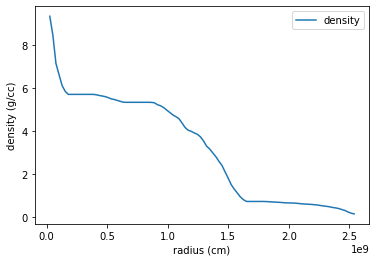

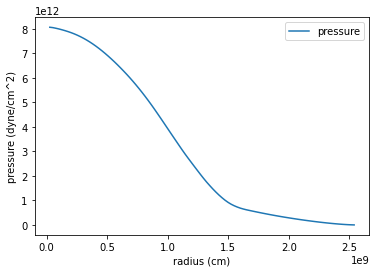

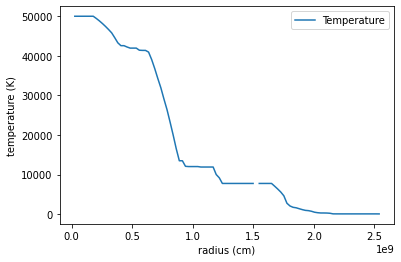

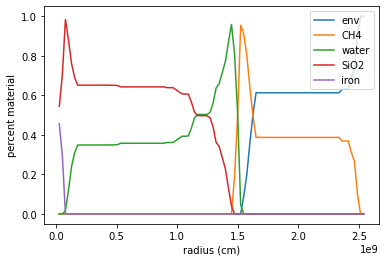

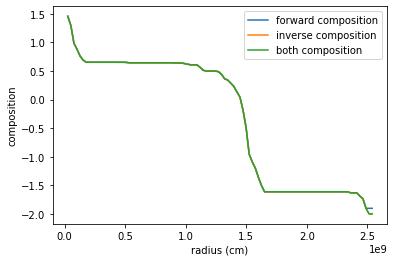

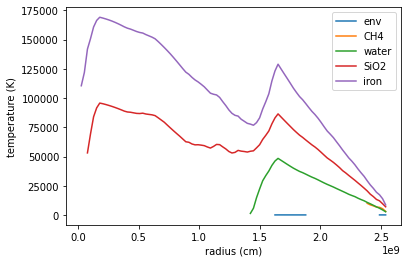

In [8]:
model = best_model( 773.332127703, catalog, max_temp=40000, min_temp=0, full_model=True, smooth=201)
model